# Stress Testing in the MtM approach

In [1]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,normalize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.losses import MeanSquaredError
import os
import IPython
import ast
from scipy.stats import norm
from scipy.optimize import minimize
import joblib
%load_ext autoreload
%autoreload 2
%aimport IS_misc_functions
from IS_misc_functions import *
from misc_functions import *
from actuarial_training import *
from MtM_training import *
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

import json

#import warnings
#warnings.filterwarnings("ignore")

Load the models

In [2]:
model_999 = keras.models.load_model("model_mtm_0999.h5",compile = False)
model_999.compile()
scaler_mtm = joblib.load('scaler_mtm.gz')

C:\Users\julia\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Consider a baseline Portfolio (as in the sensitivities study)

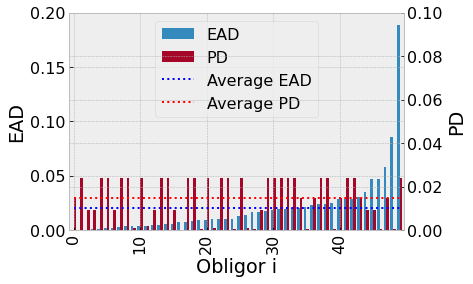

In [3]:
N_Iter = 1000 # Number of Iterations

B = 1 # Batch Size

# Number of States considered
S =17
n_obligors = 100

# Bounds for the parameters
ELGD_bounds = 0,0.6
EAD_bounds = 0,1
rho_bounds = 0.15,0.7
c_bounds = 0,0.1
g_bounds = 2,S
D_bounds = 1,1.00001
obligor_bounds = 99,100

B = 1 # Batch Size

max_obligors = obligor_bounds[1]

transition_matrix = pd.read_csv("transition_matrix_SP.csv",delimiter = ",")
PDs = np.maximum(np.array(transition_matrix["D"])/100,1e-8)
SP_dict = trans_matrix_to_dict(transition_matrix)
with open("probs.txt") as tweetfile:
    probs = json.load(tweetfile)
probs = {float(k):float(v) for k,v in probs.items()}
PDs =  np.maximum(np.array([float(k) for k,v in probs.items()])/100,1e-10)
PD_distribution = np.array([float(v) for k,v in probs.items()])
S = 17
g_bounds = 2,S
g_vals = np.arange(g_bounds[0],g_bounds[1])
g_probs = np.flip(np.concatenate([[0.0001,0.0001],PD_distribution]))
g_probs = g_probs/np.sum(g_probs)
PDs_reverted = np.flip(np.concatenate([[1e-10,1e-10],PDs]))

# Fix the randomness
np.random.seed(seed=636)

ELGD,EAD,rho,c,g,D = create_sample_MtM(ELGD_bounds,EAD_bounds,rho_bounds,c_bounds,g_bounds,D_bounds,obligor_bounds,B,
                                                   g_vals,g_probs)

LGD_Vector1 = np.zeros((1,100))
LGD_Vector2 = np.zeros((1,100))
LGD_Vector1[ELGD>0] = 0.1
LGD_Vector2[ELGD>0] = 0.45

D[D>0]=1
rho[rho>0] = 0.5

reduced_obligors = 50
N = np.zeros((1,max_obligors))
N[0,:] = np.pad(np.repeat(1,reduced_obligors),(0,max_obligors-reduced_obligors)) # Number of Obligors 
ELGD,EAD,rho,c,g,D = ELGD*N,EAD*N/np.sum(EAD*N),rho*N,c*N,g*N,D*N
LGD_Vector1 = np.zeros((1,100))
LGD_Vector2 = np.zeros((1,100))
LGD_Vector1[ELGD>0] = 0.1
LGD_Vector2[ELGD>0] = 0.45


ELGD_base,EAD_base,rho_base,c_base,g_base,D_base = ELGD,EAD,rho,c,g,D


# Convert g to PDs
g = np.maximum(g,4)
PD_Vector = np.array([PDs_reverted[int(g_val)-2] for g_val in g[0] if g_val != 0])
# Sort by EAD
tup = [(e,p) for (e,p) in zip(EAD[EAD>0],PD_Vector)]
tup.sort(key = lambda x: x[0]) 
EAD_Sorted = [e for (e,p) in tup]
PD_Sorted = [p for (e,p) in tup]
df =pd.DataFrame(tup)
df.columns = ["EAD","PD"]

ax = df.plot(kind="bar",width = 0.8)
ax2 = ax.twinx()
for r in ax.patches[len(df):]:
    r.set_transform(ax2.transData)
ax.plot([np.mean(EAD_Sorted)]*50,color = "blue",linestyle = "dotted",label = "Average EAD")
ax2.plot([np.mean(PD_Sorted)]*50,color = "red",linestyle = "dotted",label = "Average PD")
ax2.set_ylim(0, 0.1)
ax.set_ylim(0, 0.2)
ax.set_xticks([0,10,20,30,40])
ax.set_ylabel('EAD')
ax2.set_ylabel('PD')
ax.set_xlabel('Obligor i')
# Combining legends
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
ax.legend([handles[i] for i in [1,2,0,3]],
          [labels[i] for i in [1,2,0,3]],loc = "upper center") # Rearrange Order
plt.savefig('Plots/mtm_sensitivity_Portfolio.pdf', format='pdf',bbox_inches='tight')
plt.show()

Set up the MDB portfolios

In [4]:
transition_matrix = pd.read_csv("transition_matrix_SP.csv",delimiter = ",")
PDs = np.maximum(np.array(transition_matrix["D"])/100,1e-8)
SP_dict = trans_matrix_to_dict(transition_matrix)
with open("probs.txt") as tweetfile:
    probs = json.load(tweetfile)
probs = {float(k):float(v) for k,v in probs.items()}
PDs =  np.maximum(np.array([float(k) for k,v in probs.items()])/100,1e-10)
PD_distribution = np.array([float(v) for k,v in probs.items()])
S = 17



by_country = pd.read_excel("MDB portfolios.xlsx", sheet_name='by country')
maturity = pd.read_excel("MDB portfolios.xlsx", sheet_name='maturity')
summary = pd.read_excel("MDB portfolios.xlsx", sheet_name='summary of current info')
comments = pd.read_excel("MDB portfolios.xlsx", sheet_name='comments')
rating = pd.read_excel("MDB portfolios.xlsx", sheet_name='rating')
transition_matrix_SP = pd.read_csv("transition_matrix_SP.csv",delimiter = ",",index_col = 0)
transition_matrix_RC = pd.read_csv("transition_matrix_RC.csv",delimiter = ";",index_col = 0)

SP_dict = trans_matrix_to_dict(transition_matrix_SP)
RC_dict = trans_matrix_to_dict(transition_matrix_RC)

#Small Tolerance to avoid 0s
tolerance = 10e-10

# list of banks
bank_names = list(summary.iloc[:,0])

# Exclude EIB and NIB from being considered
bank_names = [b for b in bank_names if b != "EIB" and b!= "NIB"]


# SP Rating of Countries
country_sp = {rating["Country"][i].lower().replace(" ", ""): 
              str(rating["sp_cb"][i]).replace(" ", "")  for i in range(len(rating["sp_cb"]))}

def create_PD_dict(transition_matrix,unrated_b_minus = True):
    country_dict = country_sp #copy.copy(country_sp)

    # The PDs of Rating Classes
    Rating_PD = {transition_matrix.index[i]: np.maximum(transition_matrix["D"][i],tolerance)  for i in range(len(transition_matrix.index))}

    # Companies with D rating are not in default wrt other MDBs:
    Rating_PD["D"] = Rating_PD["Cs"]
    Rating_PD["SD"] = Rating_PD["Cs"]
    
    if unrated_b_minus:
        for country_rating in set(country_dict.values()):
            if country_rating in ["C","CC","CCC-","CCC","CCC+"]:
                Rating_PD[country_rating] = Rating_PD["Cs"]
            if country_rating in ['0',0]:
                Rating_PD[country_rating] = Rating_PD["B-"] 

#         for country_rating in set(country_dict.values()):
#             if country_rating not in Rating_PD.keys():
#                 Rating_PD[country_rating] = "nan"

        for country in country_dict:
            if country_dict[country] in ["C","CC","CCC-","CCC","CCC+"]:
                country_dict[country] = "Cs"
            if country_dict[country] in ['0',0]:
                country_dict[country] = "B-"
    
    elif unrated_b_minus == False:

        # Adjust the PDs further 
        for country_rating in set(country_dict.values()):
            if country_rating in ["C","CC",'0',0,"CCC-","CCC","CCC+"]:
                Rating_PD[country_rating] = Rating_PD["Cs"] 

        for country_rating in set(country_dict.values()):
            if country_rating not in Rating_PD.keys():
                Rating_PD[country_rating] = "nan"

        for country in country_dict:
            if country_dict[country] in ["C","CC",'0',0,"CCC-","CCC","CCC+"]:
                country_dict[country] = "Cs"

    # Assign the ratings to the countries
    countries_PD = {country.lower().replace(" ", ""): Rating_PD[country_dict[country]] for country in country_dict.keys()}
    return countries_PD

countries_PD_SP = create_PD_dict(transition_matrix_SP)
countries_PD_RC = create_PD_dict(transition_matrix_RC)

spaces = np.where(pd.isnull(by_country.iloc[:,3]))[0]
spaces[0] = 1
spaces = np.append(spaces,len(by_country.iloc[:,3]))

def create_portfolio(q = 0.99, ELGD_val = 0.45,
                     transition_matrix = transition_matrix_SP,
                     countries_PD = countries_PD_SP,
                    constant_rho = False,
                    rho = 0.35):
    portfolios = {}
    for i in range(len(bank_names)):
        considered_countries = np.array(by_country.iloc[:,1][(spaces[i]+1):(spaces[i+1]-1)])
        PD = []
        EAD = []
        g = []
        for j in range(len(considered_countries)):
            country = considered_countries[j].lower().replace(" ", "")
            if country in countries_PD.keys() and countries_PD[country] != 'nan': # nur anlegen wenn existent
                PD.append(countries_PD[country] /100)
                EAD.append(by_country.iloc[:,3][(spaces[i]+1)+j])
                g.append(S-list(transition_matrix.index).index(country_sp[country]))
        EAD = EAD/np.sum(np.array(EAD,dtype = np.float64))
        PD = np.array(PD)
        ELGD = np.array([ELGD_val]*len(EAD))
        if constant_rho:
            def to_solve(om):
                b = (0.11852-0.05478*np.log(PD))**2
                R_corr = rho
                K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)
                alpha_X =  gamma.ppf(q,a =0.25, scale = 1/0.25)
                return  (np.abs(ELGD*PD*om*(alpha_X-1)-K))
        else:
            def to_solve(om):
                b = (0.11852-0.05478*np.log(PD))**2
                R_corr = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50)))
                K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)
                alpha_X =  gamma.ppf(q,a =0.25, scale = 1/0.25)
                return  (np.abs(ELGD*PD*om*(alpha_X-1)-K))
        omega = fsolve(to_solve,[0.25]*len(EAD))
        omega = np.minimum(omega,1)
        #bnds = [(0,1) for i in range(len(EAD))]
        #omega = minimize(to_solve,[1]*len(EAD), bounds=bnds).x
        portfolios[bank_names[i]] = [EAD,ELGD,PD,omega,g]
    return portfolios

portfolios_0999_all = create_portfolio(q = 0.999,transition_matrix = transition_matrix_SP,countries_PD = countries_PD_SP)

scaler_actuarial = joblib.load('scaler_actuarial.gz')

portfolios_0999 = {}
for b in  ['AFDB', 'CAF','EBRD']:
    portfolios_0999[b] = portfolios_0999_all[b]

C:\Users\julia\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Fix the number of Monte-Carlo Simulations

In [53]:
n_mc = 1000000 

# Increase PD, decrease asset correlation

In [16]:
pd_increase = range(10)

   
GA_NN_PF_01_img1 = {}
GA_NN_PF_045_img1 = {}
GA_MC_PF_01_img1 = {}
GA_MC_PF_045_img1 = {}

coupons = 0.01
for portfolio in portfolios_0999:
    GA_NN_PF_01_img1[portfolio] = []
    GA_NN_PF_045_img1[portfolio] = []
    GA_MC_PF_01_img1[portfolio] = []
    GA_MC_PF_045_img1[portfolio] = []
    for increase in pd_increase:
        # 10 %
        EAD,ELGD,PD,omega,g = portfolios_0999[portfolio]
        ELGD = np.array([0.1]*len(EAD))
        new_PD = PDs[np.minimum(13-(np.array(g)-increase),12)]
        rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50)))
        rho =  rho*(0.9)**increase
        rho = np.reshape(np.append(rho,[0]*(100-len(EAD))),(1,100))    
        c = np.array([coupons]*len(EAD))
        c = np.reshape(np.append(c,[0]*(100-len(EAD))),(1,100))
        g = np.array(g)
        g = np.reshape(np.append(g,[0]*(100-len(EAD))),(1,100))
        D= np.array([1]*len(EAD))
        D=  np.reshape(np.append(D,[0]*(100-len(EAD))),(1,100))
        EAD = np.reshape(np.append(EAD,[0]*(100-len(EAD))),(1,100))
        ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
        
        Input_MtM = np.concatenate([ELGD,EAD,rho,c,np.array(np.maximum(g-increase,1)),D],axis =1)
        GA_approx_mtm = GA_GM(PD = 0, ELGD =ELGD[0,:][EAD[0,:]>0],
                                   A = EAD[0,:][EAD[0,:]>0], M= D[0,:][EAD[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= np.array(np.maximum(g[0,:][EAD[0,:]>0]-increase,1),dtype = int),
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho[0,:][EAD[0,:]>0],
                     c = c[EAD>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
        
        Input_mtm_2 = np.concatenate([Input_MtM,np.reshape(GA_approx_mtm,(1,1))],axis = 1)
        GA_NN_PF_01_img1[portfolio].append(model_999.predict(scaler_mtm.transform(Input_mtm_2))[0][0])
        
        MC = MC_IS_MtM(LGD_Vector1[0,:],EAD[0,:],rho[0,:],c[0,:],np.array(np.maximum(g[0,:]-increase,1)),
                               SP_dict,D[0,:],r_nelson,
                               q=0.999,n = n_mc)
        GA_MC_PF_01_img1[portfolio].append(MC)
        
        # 45 %
        EAD,ELGD,PD,omega,g = portfolios_0999[portfolio]
        ELGD = np.array([0.45]*len(EAD))
        new_PD = PDs[np.minimum(13-(np.array(g)-increase),12)]
        rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50)))
        rho =  rho*(0.9)**increase
        rho = np.reshape(np.append(rho,[0]*(100-len(EAD))),(1,100))       
        c = np.array([coupons]*len(EAD))
        c = np.reshape(np.append(c,[0]*(100-len(EAD))),(1,100))
        g = np.array(g)
        g = np.reshape(np.append(g,[0]*(100-len(EAD))),(1,100))
        D= np.array([1]*len(EAD))
        D=  np.reshape(np.append(D,[0]*(100-len(EAD))),(1,100))
        EAD = np.reshape(np.append(EAD,[0]*(100-len(EAD))),(1,100))
        ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
        
        Input_MtM = np.concatenate([ELGD,EAD,rho,c,np.array(np.maximum(g-increase,1),dtype = int),D],axis =1)
        GA_approx_mtm = GA_GM(PD = 0, ELGD =ELGD[0,:][EAD[0,:]>0],
                                   A = EAD[0,:][EAD[0,:]>0], M= D[0,:][EAD[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= np.array(np.maximum(g[0,:][EAD[0,:]>0]-increase,1),dtype = int),
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho[0,:][EAD[0,:]>0],
                     c = c[EAD>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
        
        Input_mtm_2 = np.concatenate([Input_MtM,np.reshape(GA_approx_mtm,(1,1))],axis = 1)
        GA_NN_PF_045_img1[portfolio].append(model_999.predict(scaler_mtm.transform(Input_mtm_2))[0][0])       

        MC = MC_IS_MtM(LGD_Vector2[0,:],EAD[0,:],rho[0,:],c[0,:],np.array(np.maximum(g[0,:]-increase,1)),
                               SP_dict,D[0,:],r_nelson,
                               q=0.999,n = n_mc)
        GA_MC_PF_045_img1[portfolio].append(MC)        
        

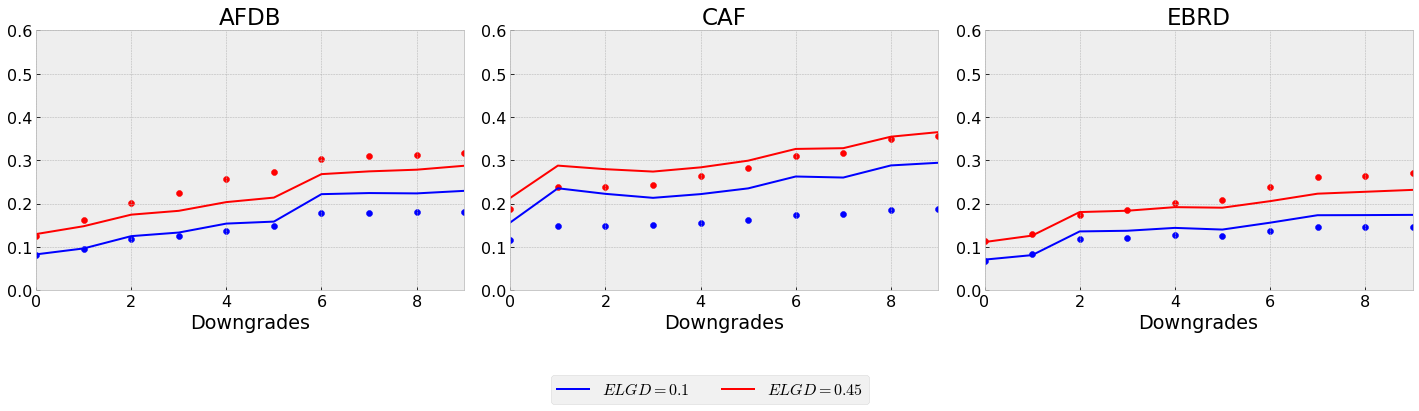

In [17]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(1, len(portfolios_0999), figsize=(20, 5))

# Flatten the 2D array of axes so we can iterate over it
axs = axs.flatten()

# Set x and y limits (replace with the range you want)
x_limits = [min(pd_increase), max(pd_increase)]  # Example: based on pd_increase
y_limits = [0, 0.6]  # Replace with appropriate y-limits based on your data

# Initialize lists for the plot handles and labels for the global legend
handles = []
labels = []





# Apply the x and y limits for the first subplot
axs[0].set_xlim(x_limits)
axs[0].set_ylim(y_limits)
axs[0].set_xlabel("Downgrades")
axs[0].set_ylabel("GA")



# Define the base lines for the legend outside the loop
line1, = axs[0].plot([], [], label=r"$ELGD = 0.1$", color="blue")  # Dummy line for legend
line2, = axs[0].plot([], [], label=r"$ELGD = 0.45$", color="red")  # Dummy line for legend
handles.extend([line1, line2])
labels.extend([r"$ELGD = 0.1$", r"$ELGD = 0.45$"])
# Plot for other portfolios
i = 0
for portfolio in portfolios_0999:
#     if i == 0:
#         # Plot for the base portfolio
#         line1, = axs[0].plot(pd_increase, GA_NN_01_img1, label=r"$ELGD = 0.1$", color="blue")
#         line2, = axs[0].plot(pd_increase, GA_NN_045_img1, label=r"$ELGD = 0.45$", color="red")
# #         axs[0].scatter(pd_increase, GA_NN_PF_01_img1[portfolio], label=r"$ELGD = 0.1$", color="blue")
# #         axs[0].scatter(pd_increase, GA_NN_PF_045_img1[portfolio], label=r"$ELGD = 0.45$", color="red")
#         axs[i].scatter(pd_increase, GA_MC_01_img1, color="blue")
#         axs[i].scatter(pd_increase, GA_MC_045_img1, color="red")
#         axs[0].set_title("Base Portfolio")
#         i+=1
        
    axs[i].plot(pd_increase, GA_NN_PF_01_img1[portfolio], color="blue")
    axs[i].plot(pd_increase, GA_NN_PF_045_img1[portfolio], color="red")
#         axs[i].scatter(pd_increase, GA_NN_PF_01_img1[portfolio], color="blue")
#         axs[i].scatter(pd_increase, GA_NN_PF_045_img1[portfolio], color="red")
    axs[i].set_title(str(portfolio))
    axs[i].scatter(pd_increase, GA_MC_PF_01_img1[portfolio], color="blue")
    axs[i].scatter(pd_increase, GA_MC_PF_045_img1[portfolio], color="red")
    # Apply the same x and y limits for each subplot
    axs[i].set_xlim(x_limits)
    axs[i].set_ylim(y_limits)

    # Show x-axis labels only for the last row of subplots
    axs[i].set_xlabel("Downgrades")
    axs[i].set_ylabel("")
    i += 1
        


# Add a single legend to the figure, using the collected handles and labels
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.05))

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as a PDF
plt.savefig('Plots/mtm_sensitivity_PD_increase_rho_decrease.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


# Increase PD, increase asset correlation

In [18]:
pd_increase = range(10)

   
GA_NN_PF_01_img2 = {}
GA_NN_PF_045_img2 = {}
GA_MC_PF_01_img2 = {}
GA_MC_PF_045_img2 = {}

coupons = 0.01
for portfolio in portfolios_0999:
    GA_NN_PF_01_img2[portfolio] = []
    GA_NN_PF_045_img2[portfolio] = []
    GA_MC_PF_01_img2[portfolio] = []
    GA_MC_PF_045_img2[portfolio] = []
    for increase in pd_increase:
        # 10 %
        EAD,ELGD,PD,omega,g = portfolios_0999[portfolio]
        ELGD = np.array([0.1]*len(EAD))
        new_PD = PDs[np.minimum(13-(np.array(g)-increase),12)]
        rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50)))
        rho =  rho*(1.1)**increase
        rho = np.reshape(np.append(rho,[0]*(100-len(EAD))),(1,100))    
        c = np.array([coupons]*len(EAD))
        c = np.reshape(np.append(c,[0]*(100-len(EAD))),(1,100))
        g = np.array(g)
        g = np.reshape(np.append(g,[0]*(100-len(EAD))),(1,100))
        D= np.array([1]*len(EAD))
        D=  np.reshape(np.append(D,[0]*(100-len(EAD))),(1,100))
        EAD = np.reshape(np.append(EAD,[0]*(100-len(EAD))),(1,100))
        ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
        
        Input_MtM = np.concatenate([ELGD,EAD,rho,c,np.array(np.maximum(g-increase,1)),D],axis =1)
        GA_approx_mtm = GA_GM(PD = 0, ELGD =ELGD[0,:][EAD[0,:]>0],
                                   A = EAD[0,:][EAD[0,:]>0], M= D[0,:][EAD[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= np.array(np.maximum(g[0,:][EAD[0,:]>0]-increase,1),dtype = int),
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho[0,:][EAD[0,:]>0],
                     c = c[EAD>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
        
        Input_mtm_2 = np.concatenate([Input_MtM,np.reshape(GA_approx_mtm,(1,1))],axis = 1)
        GA_NN_PF_01_img2[portfolio].append(model_999.predict(scaler_mtm.transform(Input_mtm_2))[0][0])
        
        MC = MC_IS_MtM(LGD_Vector1[0,:],EAD[0,:],rho[0,:],c[0,:],np.array(np.maximum(g[0,:]-increase,1)),
                               SP_dict,D[0,:],r_nelson,
                               q=0.999,n = n_mc)
        GA_MC_PF_01_img2[portfolio].append(MC)
        
        # 45 %
        EAD,ELGD,PD,omega,g = portfolios_0999[portfolio]
        ELGD = np.array([0.45]*len(EAD))
        new_PD = PDs[np.minimum(13-(np.array(g)-increase),12)]
        rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50)))
        rho =  rho*(1.1)**increase
        rho = np.reshape(np.append(rho,[0]*(100-len(EAD))),(1,100))       
        c = np.array([coupons]*len(EAD))
        c = np.reshape(np.append(c,[0]*(100-len(EAD))),(1,100))
        g = np.array(g)
        g = np.reshape(np.append(g,[0]*(100-len(EAD))),(1,100))
        D= np.array([1]*len(EAD))
        D=  np.reshape(np.append(D,[0]*(100-len(EAD))),(1,100))
        EAD = np.reshape(np.append(EAD,[0]*(100-len(EAD))),(1,100))
        ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
        
        Input_MtM = np.concatenate([ELGD,EAD,rho,c,np.array(np.maximum(g-increase,1),dtype = int),D],axis =1)
        GA_approx_mtm = GA_GM(PD = 0, ELGD =ELGD[0,:][EAD[0,:]>0],
                                   A = EAD[0,:][EAD[0,:]>0], M= D[0,:][EAD[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= np.array(np.maximum(g[0,:][EAD[0,:]>0]-increase,1),dtype = int),
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho[0,:][EAD[0,:]>0],
                     c = c[EAD>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
        
        Input_mtm_2 = np.concatenate([Input_MtM,np.reshape(GA_approx_mtm,(1,1))],axis = 1)
        GA_NN_PF_045_img2[portfolio].append(model_999.predict(scaler_mtm.transform(Input_mtm_2))[0][0])       

        MC = MC_IS_MtM(LGD_Vector2[0,:],EAD[0,:],rho[0,:],c[0,:],np.array(np.maximum(g[0,:]-increase,1)),
                               SP_dict,D[0,:],r_nelson,
                               q=0.999,n = n_mc)
        GA_MC_PF_045_img2[portfolio].append(MC)        
        

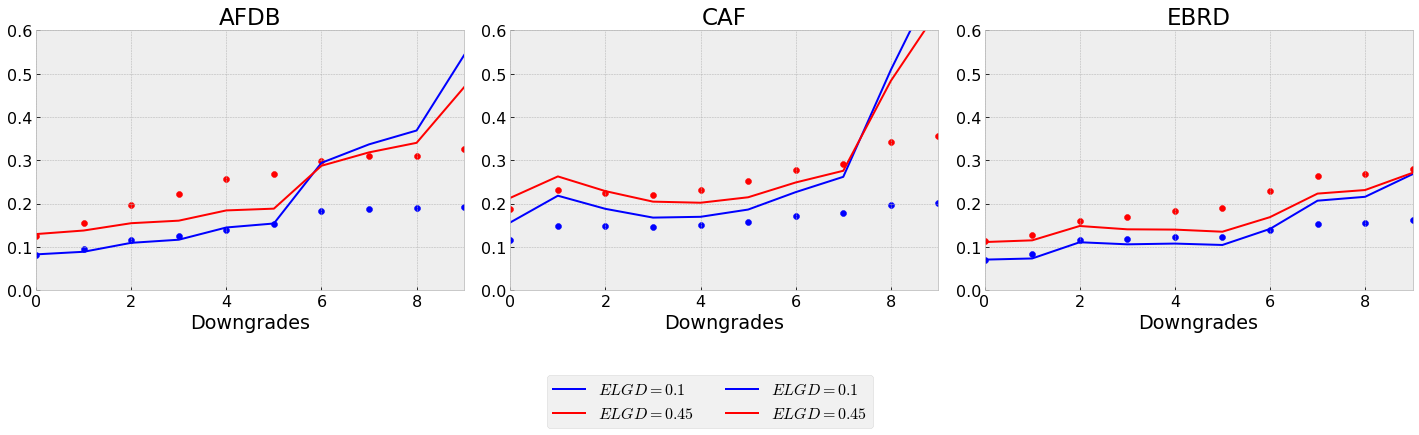

In [19]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(1, len(portfolios_0999), figsize=(20, 5))

# Flatten the 2D array of axes so we can iterate over it
axs = axs.flatten()

# Set x and y limits (replace with the range you want)
x_limits = [min(pd_increase), max(pd_increase)]  # Example: based on pd_increase
y_limits = [0, 0.6]  # Replace with appropriate y-limits based on your data

# Initialize lists for the plot handles and labels for the global legend
handles = []
labels = []





# Define the base lines for the legend outside the loop
line1, = axs[0].plot([], [], label=r"$ELGD = 0.1$", color="blue")  # Dummy line for legend
line2, = axs[0].plot([], [], label=r"$ELGD = 0.45$", color="red")  # Dummy line for legend
handles.extend([line1, line2])
labels.extend([r"$ELGD = 0.1$", r"$ELGD = 0.45$"])
# Plot for other portfolios
i = 0
for portfolio in portfolios_0999:
#     if i == 0:
#         # Plot for the base portfolio
#         line1, = axs[0].plot(pd_increase, GA_NN_01_img2, label=r"$ELGD = 0.1$", color="blue")
#         line2, = axs[0].plot(pd_increase, GA_NN_045_img2, label=r"$ELGD = 0.45$", color="red")
# #         axs[0].scatter(pd_increase, GA_NN_PF_01_img2[portfolio], label=r"$ELGD = 0.1$", color="blue")
# #         axs[0].scatter(pd_increase, GA_NN_PF_045_img2[portfolio], label=r"$ELGD = 0.45$", color="red")
#         axs[i].scatter(pd_increase, GA_MC_01_img2, color="blue")
#         axs[i].scatter(pd_increase, GA_MC_045_img2, color="red")
#         axs[0].set_title("Base Portfolio")
#         i+=1
        
    axs[i].plot(pd_increase, GA_NN_PF_01_img2[portfolio], color="blue")
    axs[i].plot(pd_increase, GA_NN_PF_045_img2[portfolio], color="red")
#         axs[i].scatter(pd_increase, GA_NN_PF_01_img2[portfolio], color="blue")
#         axs[i].scatter(pd_increase, GA_NN_PF_045_img2[portfolio], color="red")
    axs[i].set_title(str(portfolio))
    axs[i].scatter(pd_increase, GA_MC_PF_01_img2[portfolio], color="blue")
    axs[i].scatter(pd_increase, GA_MC_PF_045_img2[portfolio], color="red")
    # Apply the same x and y limits for each subplot
    axs[i].set_xlim(x_limits)
    axs[i].set_ylim(y_limits)

    # Show x-axis labels only for the last row of subplots
    axs[i].set_xlabel("Downgrades")
    axs[i].set_ylabel("")
    i += 1
        
# Collect the handles and labels for the legend
handles.extend([line1, line2])
labels.extend([r"$ELGD = 0.1$", r"$ELGD = 0.45$"])

# Add a single legend to the figure, using the collected handles and labels
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.05))

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as a PDF
plt.savefig('Plots/mtm_sensitivity_PD_increase_rho_increase.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


# Vary PD and correlations

Do the calculations for the synthetic base portfolio

In [27]:
pd_increase = range(10)
GA_NN_01 = []
GA_NN_045 = []
GA_MC_01 = []
GA_MC_045 = []



for increase in pd_increase:    
    ELGD,EAD,rho,c,g,D = ELGD_base,EAD_base,rho_base,c_base,g_base,D_base
    g[g != 0] = np.maximum(g[g != 0] -increase,0)
    GA_approx_01 = GA_GM(PD = 0, ELGD =LGD_Vector1[0,:][EAD[0,:]>0],
                                       A = EAD[0,:][EAD[0,:]>0], 
                             M= D[0,:][EAD[0,:]>0],
                          q=0.999,        
                         r = r_nelson,
                         T=1,
                         g= g[0,:][EAD[0,:]>0],
                         trans_prob=SP_dict["trans_prob"],#N times S matrix
                         psi = 0.4, # Market Sharpe Ratio,
                         rho = rho[0,:][EAD[0,:]>0],
                         c = c[0,:][EAD[0,:]>0],
                        nu =0.25,               
                         S = S, # Number of States of Rating
                         default_only = False,
                          LGD_constant = False)
    Input_01 = np.concatenate([LGD_Vector1 ,EAD ,rho ,c,g,D,
                                np.reshape(GA_approx_01,(1,1))],axis =1)
    GA_NN_01.append(model_999.predict(scaler_mtm.transform(Input_01), verbose=0)[0][0])
    MC = MC_IS_MtM(LGD_Vector1[0,:],EAD[0,:],rho[0,:],c[0,:],g[0,:],
                           SP_dict,D[0,:],r_nelson,
                           q=0.999,n = n_mc)
    GA_MC_01.append(MC)   
    
    
    GA_approx_045 = GA_GM(PD = 0, ELGD =LGD_Vector2[0,:][EAD[0,:]>0],
                                       A = EAD[0,:][EAD[0,:]>0], 
                             M= D[0,:][EAD[0,:]>0],
                          q=0.999,        
                         r = r_nelson,
                         T=1,
                         g= g[0,:][EAD[0,:]>0],
                         trans_prob=SP_dict["trans_prob"],#N times S matrix
                         psi = 0.4, # Market Sharpe Ratio,
                         rho = rho[0,:][EAD[0,:]>0],
                         c = c[0,:][EAD[0,:]>0],
                        nu =0.25,               
                         S = S, # Number of States of Rating
                         default_only = False,
                          LGD_constant = False)
    Input_045 = np.concatenate([LGD_Vector2 ,EAD ,rho ,c,g,D,
                                np.reshape(GA_approx_01,(1,1))],axis =1)
    GA_NN_045.append(model_999.predict(scaler_mtm.transform(Input_045), verbose=0)[0][0])
    MC = MC_IS_MtM(LGD_Vector2[0,:],EAD[0,:],rho[0,:],c[0,:],g[0,:],
                           SP_dict,D[0,:],r_nelson,
                           q=0.999,n = n_mc)
    GA_MC_045.append(MC)   
    

In [55]:
pd_increase = range(10)

   
GA_NN_PF_01 = {}
GA_NN_PF_045 = {}
GA_MC_PF_01 = {}
GA_MC_PF_045 = {}

coupons = 0.01
for portfolio in portfolios_0999:
    GA_NN_PF_01[portfolio] = []
    GA_NN_PF_045[portfolio] = []
    GA_MC_PF_01[portfolio] = []
    GA_MC_PF_045[portfolio] = []
    for increase in pd_increase:
        # 10 %
        EAD,ELGD,PD,omega,g = portfolios_0999[portfolio]
        ELGD = np.array([0.1]*len(EAD))
        new_PD = PDs[np.minimum(13-(np.array(g)-increase),12)]
        rho = 0.12*(1-np.exp(-50*new_PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*new_PD))/(1-np.exp(-50)))
        rho = np.reshape(np.append(rho,[0]*(100-len(EAD))),(1,100))     
        c = np.array([coupons]*len(EAD))
        c = np.reshape(np.append(c,[0]*(100-len(EAD))),(1,100))
        g = np.array(g)
        g[g != 0] = np.maximum(g[g != 0] -increase,1)
        g = np.reshape(np.append(g,[0]*(100-len(EAD))),(1,100))
        D= np.array([1]*len(EAD))
        D=  np.reshape(np.append(D,[0]*(100-len(EAD))),(1,100))
        EAD = np.reshape(np.append(EAD,[0]*(100-len(EAD))),(1,100))
        ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
        
        Input_MtM = np.concatenate([ELGD,EAD,rho,c,g,D],axis =1)
        GA_approx_mtm = GA_GM(PD = 0, ELGD =ELGD[0,:][EAD[0,:]>0],
                                   A = EAD[0,:][EAD[0,:]>0], M= D[0,:][EAD[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= g[0,:][EAD[0,:]>0],
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho[0,:][EAD[0,:]>0],
                     c = c[EAD>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
        
        Input_mtm_2 = np.concatenate([Input_MtM,np.reshape(GA_approx_mtm,(1,1))],axis = 1)
        GA_NN_PF_01[portfolio].append(model_999.predict(scaler_mtm.transform(Input_mtm_2))[0][0])
        
        MC = MC_IS_MtM(LGD_Vector1[0,:],EAD[0,:],rho[0,:],c[0,:],g[0,:],
                               SP_dict,D[0,:],r_nelson,
                               q=0.999,n = n_mc)
        GA_MC_PF_01[portfolio].append(MC)
        
        # 45 %
        EAD,ELGD,PD,omega,g = portfolios_0999[portfolio]
        ELGD = np.array([0.45]*len(EAD))
        new_PD = PDs[np.minimum(13-(np.array(g)-increase),12)]
        rho = 0.12*(1-np.exp(-50*new_PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*new_PD))/(1-np.exp(-50)))        
        rho = np.reshape(np.append(rho,[0]*(100-len(EAD))),(1,100))     
        c = np.array([coupons]*len(EAD))
        c = np.reshape(np.append(c,[0]*(100-len(EAD))),(1,100))
        g = np.array(g)
        g[g != 0] = np.maximum(g[g != 0] -increase,1)
        g = np.reshape(np.append(g,[0]*(100-len(EAD))),(1,100))
        D= np.array([1]*len(EAD))
        D=  np.reshape(np.append(D,[0]*(100-len(EAD))),(1,100))
        EAD = np.reshape(np.append(EAD,[0]*(100-len(EAD))),(1,100))
        ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
        
        Input_MtM = np.concatenate([ELGD,EAD,rho,c,g,D],axis =1)
        GA_approx_mtm = GA_GM(PD = 0, ELGD =ELGD[0,:][EAD[0,:]>0],
                                   A = EAD[0,:][EAD[0,:]>0], M= D[0,:][EAD[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= g[0,:][EAD[0,:]>0],
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho[0,:][EAD[0,:]>0],
                     c = c[EAD>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
        
        Input_mtm_2 = np.concatenate([Input_MtM,np.reshape(GA_approx_mtm,(1,1))],axis = 1)
        GA_NN_PF_045[portfolio].append(model_999.predict(scaler_mtm.transform(Input_mtm_2))[0][0])       

        MC = MC_IS_MtM(LGD_Vector2[0,:],EAD[0,:],rho[0,:],c[0,:],g[0,:],
                               SP_dict,D[0,:],r_nelson,
                               q=0.999,n = n_mc)
        GA_MC_PF_045[portfolio].append(MC)        
        

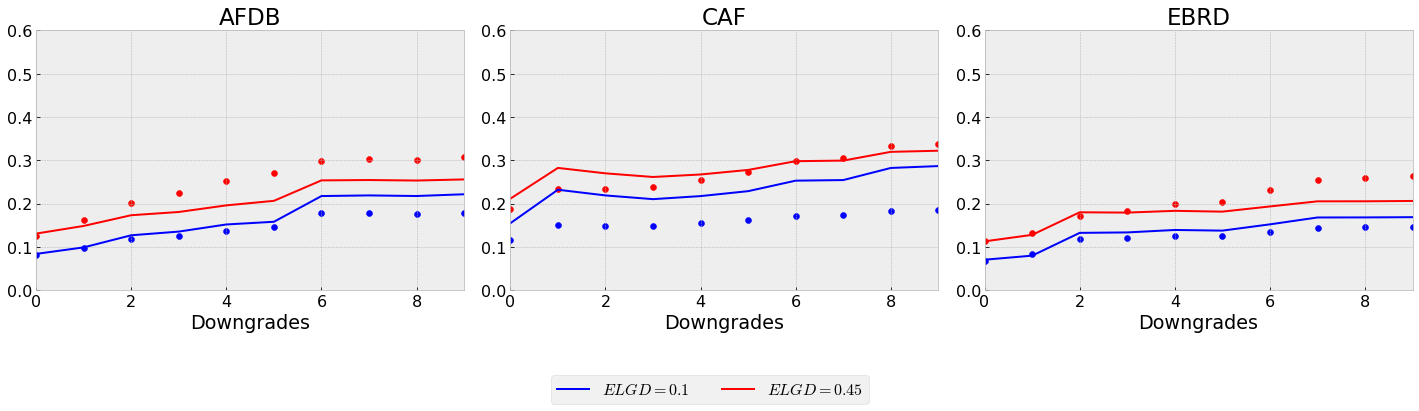

In [56]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(1, len(portfolios_0999), figsize=(20, 5))

# Flatten the 2D array of axes so we can iterate over it
axs = axs.flatten()

# Set x and y limits (replace with the range you want)
x_limits = [min(pd_increase), max(pd_increase)]  # Example: based on pd_increase
y_limits = [0, 0.6]  # Replace with appropriate y-limits based on your data

# Initialize lists for the plot handles and labels for the global legend
handles = []
labels = []





# Apply the x and y limits for the first subplot
axs[0].set_xlim(x_limits)
axs[0].set_ylim(y_limits)
axs[0].set_xlabel("Downgrades")
axs[0].set_ylabel("GA")


# Plot for other portfolios
i = 0
for portfolio in portfolios_0999:
#     if i == 0:
#         # Plot for the base portfolio
#         line1, = axs[0].plot(pd_increase, GA_NN_01, label=r"$ELGD = 0.1$", color="blue")
#         line2, = axs[0].plot(pd_increase, GA_NN_045, label=r"$ELGD = 0.45$", color="red")
# #         axs[0].scatter(pd_increase, GA_NN_PF_01[portfolio], label=r"$ELGD = 0.1$", color="blue")
# #         axs[0].scatter(pd_increase, GA_NN_PF_045[portfolio], label=r"$ELGD = 0.45$", color="red")
#         axs[i].scatter(pd_increase, GA_MC_01, color="blue")
#         axs[i].scatter(pd_increase, GA_MC_045, color="red")
#         axs[0].set_title("Base Portfolio")
#         i+=1
        
    axs[i].plot(pd_increase, GA_NN_PF_01[portfolio], color="blue")
    axs[i].plot(pd_increase, GA_NN_PF_045[portfolio], color="red")
#         axs[i].scatter(pd_increase, GA_NN_PF_01[portfolio], color="blue")
#         axs[i].scatter(pd_increase, GA_NN_PF_045[portfolio], color="red")
    axs[i].set_title(str(portfolio))
    axs[i].scatter(pd_increase, GA_MC_PF_01[portfolio], color="blue")
    axs[i].scatter(pd_increase, GA_MC_PF_045[portfolio], color="red")
    # Apply the same x and y limits for each subplot
    axs[i].set_xlim(x_limits)
    axs[i].set_ylim(y_limits)

    # Show x-axis labels only for the last row of subplots
    axs[i].set_xlabel("Downgrades")
    axs[i].set_ylabel("")
    i += 1
        
# Collect the handles and labels for the legend
handles.extend([line1, line2])
labels.extend([r"$ELGD = 0.1$", r"$ELGD = 0.45$"])

# Add a single legend to the figure, using the collected handles and labels
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.05))

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as a PDF
plt.savefig('Plots/mtm_sensitivity_PD_rho_increase.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


# Only vary the EAD concentration

First define a function to compute $\alpha$ sucht hat  exposures with 

$$
E_i' = \frac{E_i^\alpha}{\sum_{i}E_i^\alpha}
$$

lead to a target HHI value

In [57]:
def determine_alpha(exposures,target_HHI,init_val = 1.25):
    def target(alpha):
        exposures_new = exposures**alpha/(np.sum(exposures**alpha))
        return np.abs(np.sum((exposures_new/np.sum(exposures_new))**2)-target_HHI)
    alpha_opt = minimize(target,init_val).x
    return alpha_opt

Change first the synthetic portfolio

In [58]:
GA_NN_01_HHI = []
GA_NN_045_HHI = []
GA_MC_01_HHI = []
GA_MC_045_HHI = []

for i in range(8):    
    ELGD,EAD,rho,c,g,D = ELGD_base,EAD_base,rho_base,c_base,g_base.astype(int),D_base
    GA_HHI_base = np.sum((EAD/np.sum(EAD))**2)
    h = GA_HHI_base*(i+9)/10    
    alpha = determine_alpha(EAD[0,:][EAD[0,:]>0],h)
    
    EAD = EAD**alpha/np.sum(EAD**alpha)
    
    GA_approx_01 = GA_GM(PD = 0, ELGD =LGD_Vector1[0,:][EAD[0,:]>0],
                                       A = EAD[0,:][EAD[0,:]>0], 
                             M= D[0,:][EAD[0,:]>0],
                          q=0.999,        
                         r = r_nelson,
                         T=1,
                         g= g[0,:][EAD[0,:]>0],
                         trans_prob=SP_dict["trans_prob"],#N times S matrix
                         psi = 0.4, # Market Sharpe Ratio,
                         rho = rho[0,:][EAD[0,:]>0],
                         c = c[0,:][EAD[0,:]>0],
                        nu =0.25,               
                         S = S, # Number of States of Rating
                         default_only = False,
                          LGD_constant = False)
    Input_01 = np.concatenate([LGD_Vector1 ,EAD ,rho ,c,g,D,
                                np.reshape(GA_approx_01,(1,1))],axis =1)
    GA_NN_01_HHI.append(model_999.predict(scaler_mtm.transform(Input_01), verbose=0)[0][0])
    MC = MC_IS_MtM(LGD_Vector1[0,:],EAD[0,:],rho[0,:],c[0,:],g[0,:],
                           SP_dict,D[0,:],r_nelson,
                           q=0.999,n = n_mc)
    GA_MC_01_HHI.append(MC)   
        
    
    
    GA_approx_045 = GA_GM(PD = 0, ELGD =LGD_Vector2[0,:][EAD[0,:]>0],
                                       A = EAD[0,:][EAD[0,:]>0], 
                             M= D[0,:][EAD[0,:]>0],
                          q=0.999,        
                         r = r_nelson,
                         T=1,
                         g= g[0,:][EAD[0,:]>0],
                         trans_prob=SP_dict["trans_prob"],#N times S matrix
                         psi = 0.4, # Market Sharpe Ratio,
                         rho = rho[0,:][EAD[0,:]>0],
                         c = c[0,:][EAD[0,:]>0],
                        nu =0.25,               
                         S = S, # Number of States of Rating
                         default_only = False,
                          LGD_constant = False)
    Input_045 = np.concatenate([LGD_Vector2 ,EAD ,rho ,c,g,D,
                                np.reshape(GA_approx_045,(1,1))],axis =1)
    GA_NN_045_HHI.append(model_999.predict(scaler_mtm.transform(Input_045), verbose=0)[0][0])
    MC = MC_IS_MtM(LGD_Vector2[0,:],EAD[0,:],rho[0,:],c[0,:],g[0,:],
                           SP_dict,D[0,:],r_nelson,
                           q=0.999,n = n_mc)
    GA_MC_045_HHI.append(MC)   
        

Then study the real portfolios

In [59]:
GA_NN_PF_01_HHI = {}
GA_NN_PF_045_HHI = {}
GA_MC_PF_01_HHI = {}
GA_MC_PF_045_HHI = {}
GA_HHI_PF = {}
coupons = 0.01
for portfolio in portfolios_0999:
    GA_NN_PF_01_HHI[portfolio] = []
    GA_NN_PF_045_HHI[portfolio] = []
    GA_MC_PF_01_HHI[portfolio] = []
    GA_MC_PF_045_HHI[portfolio] = []
    for i in range(8):  
        # 10 %
        EAD,ELGD,PD,omega,g = portfolios_0999[portfolio]

        GA_HHI_PF[portfolio] = np.sum((EAD/np.sum(EAD))**2)
        h = GA_HHI_PF[portfolio]*(i+9)/10    
        alpha_opt = determine_alpha(EAD[EAD>0],h)  
        
        ELGD = np.array([0.1]*len(EAD))        
        rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50)))
        rho = np.reshape(np.append(rho,[0]*(100-len(EAD))),(1,100))     
        c = np.array([coupons]*len(EAD))
        c = np.reshape(np.append(c,[0]*(100-len(EAD))),(1,100))
        g = np.array(g)

        g = np.reshape(np.append(g,[0]*(100-len(EAD))),(1,100))
        D= np.array([1]*len(EAD))
        D=  np.reshape(np.append(D,[0]*(100-len(EAD))),(1,100))
        EAD = np.reshape(np.append(EAD**alpha_opt/np.sum(EAD**alpha_opt),[0]*(100-len(EAD))),(1,100))
        ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
        
        Input_MtM = np.concatenate([ELGD,EAD,rho,c,g,D],axis =1)
        GA_approx_mtm = GA_GM(PD = 0, ELGD =ELGD[0,:][EAD[0,:]>0],
                                   A = EAD[0,:][EAD[0,:]>0], M= D[0,:][EAD[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= g[0,:][EAD[0,:]>0],
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho[0,:][EAD[0,:]>0],
                     c = c[EAD>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
        
        Input_mtm_2 = np.concatenate([Input_MtM,np.reshape(GA_approx_mtm,(1,1))],axis = 1)
        GA_NN_PF_01_HHI[portfolio].append(model_999.predict(scaler_mtm.transform(Input_mtm_2))[0][0])
        
        MC = MC_IS_MtM(LGD_Vector1[0,:],EAD[0,:],rho[0,:],c[0,:],g[0,:],
                               SP_dict,D[0,:],r_nelson,
                               q=0.999,n = n_mc)
        GA_MC_PF_01_HHI[portfolio].append(MC)        
        # 45 %
        EAD,ELGD,PD,omega,g = portfolios_0999[portfolio]

        GA_HHI_PF[portfolio] = np.sum((EAD/np.sum(EAD))**2)
        h = GA_HHI_PF[portfolio]*(i+9)/10    
        alpha_opt = determine_alpha(EAD[EAD>0],h)  
        
        ELGD = np.array([0.45]*len(EAD))        
        rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50)))
        rho = np.reshape(np.append(rho,[0]*(100-len(EAD))),(1,100))     
        c = np.array([coupons]*len(EAD))
        c = np.reshape(np.append(c,[0]*(100-len(EAD))),(1,100))
        g = np.array(g)
        g = np.reshape(np.append(g,[0]*(100-len(EAD))),(1,100))
        D= np.array([1]*len(EAD))
        D=  np.reshape(np.append(D,[0]*(100-len(EAD))),(1,100))
        EAD = np.reshape(np.append(EAD**alpha_opt/np.sum(EAD**alpha_opt),[0]*(100-len(EAD))),(1,100))
        ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
        
        Input_MtM = np.concatenate([ELGD,EAD,rho,c,g,D],axis =1)
        GA_approx_mtm = GA_GM(PD = 0, ELGD =ELGD[0,:][EAD[0,:]>0],
                                   A = EAD[0,:][EAD[0,:]>0], M= D[0,:][EAD[0,:]>0],
                      q=0.999,        
                     r = r_nelson,
                     T=1,
                     g= g[0,:][EAD[0,:]>0],
                     trans_prob=SP_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = rho[0,:][EAD[0,:]>0],
                     c = c[EAD>0],
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False)
        
        Input_mtm_2 = np.concatenate([Input_MtM,np.reshape(GA_approx_mtm,(1,1))],axis = 1)
        GA_NN_PF_045_HHI[portfolio].append(model_999.predict(scaler_mtm.transform(Input_mtm_2))[0][0])       
        MC = MC_IS_MtM(LGD_Vector2[0,:],EAD[0,:],rho[0,:],c[0,:],g[0,:],
                               SP_dict,D[0,:],r_nelson,
                               q=0.999,n = n_mc)
        GA_MC_PF_045_HHI[portfolio].append(MC)                
        
              

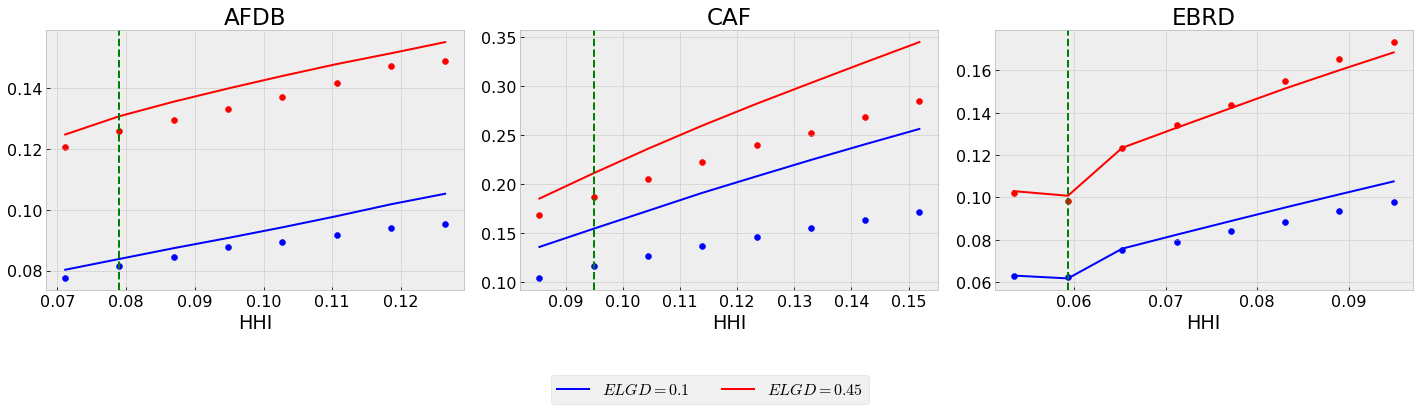

In [60]:
# Create a figure with 5 subplots
fig, axs = plt.subplots(1, len(portfolios_0999), figsize=(20, 5))

# Flatten the 2D array of axes so we can iterate over it
axs = axs.flatten()


# Initialize lists for the plot handles and labels for the global legend
handles = []
labels = []



# Apply the x and y limits for the first subplot
axs[0].set_ylabel("GA")
axs[0].set_xlabel("HHI")

# Plot for other portfolios
i = 0
for portfolio in portfolios_0999:
#     if i ==0:
#         # Plot for the base portfolio
#         line1, = axs[0].plot([GA_HHI_base*(i+9)/10 for i in range(8)]  , GA_NN_01_HHI, label=r"$ELGD = 0.1$", color="blue")
#         line2, = axs[0].plot([GA_HHI_base*(i+9)/10  for i in range(8)] , GA_NN_045_HHI, label=r"$ELGD = 0.45$", color="red")
#         line3 = axs[0].axvline(x= GA_HHI_base, color='g', linestyle='--', label='x=5')
#         axs[0].set_title("Base Portfolio")
#         axs[i].scatter([GA_HHI_base*(i+9)/10  for i in range(8)], GA_MC_01_HHI, color="blue")
#         axs[i].scatter([GA_HHI_base*(i+9)/10  for i in range(8)], GA_MC_045_HHI, color="red")
#         # Collect the handles and labels for the legend
#         handles.extend([line1, line2,line3])
#         labels.extend([r"$ELGD = 0.1$", r"$ELGD = 0.45$", "Current HHI"])     
#         i+=1
    axs[i].plot([GA_HHI_PF[portfolio]*(i+9)/10 for i in range(8)], GA_NN_PF_01_HHI[portfolio], color="blue")
    axs[i].plot([GA_HHI_PF[portfolio]*(i+9)/10 for i in range(8)], GA_NN_PF_045_HHI[portfolio], color="red")
    axs[i].axvline(x= GA_HHI_PF[portfolio], color='g', linestyle='--', label='x=5')
    axs[i].set_title(str(portfolio))
    axs[i].scatter([GA_HHI_PF[portfolio]*(i+9)/10  for i in range(8)], GA_MC_PF_01_HHI[portfolio], color="blue")
    axs[i].scatter([GA_HHI_PF[portfolio]*(i+9)/10  for i in range(8)], GA_MC_PF_045_HHI[portfolio], color="red")
    # Apply the same x and y limits for each subplot
    #axs[i].set_xlim(GA_HHI_PF[portfolio]*9/10,GA_HHI_PF[portfolio]*19/10)
    #axs[i].set_ylim()

    # Show x-axis labels only for the last row of subplots
    axs[i].set_xlabel("HHI")
    axs[i].set_ylabel('')  # Remove y-labels for other subplots
    i += 1
    

# Collect the handles and labels for the legend
handles.extend([line1, line2])
labels.extend([r"$ELGD = 0.1$", r"$ELGD = 0.45$"])
# Add a single legend to the figure, using the collected handles and labels
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.05))
# Adjust layout to prevent overlap
plt.tight_layout()
# Save the figure as a PDF
plt.savefig('Plots/mtm_sensitivity_HHI_increase_01.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


## Consider the GA Change in different scenarios:

Scenario 1: normal: PD as observed, EAD as observed, LGD = 0.1

Scenario 2: medium: PD increased by 1 category EAD slightly more concentrated, LGD = 0.1

Scenario 3: severe: PD increased by 2 categories EAD more concentrated, LGD = 0.45

Scenario 4: medium: PD increased by 3 categories EAD much more concentrated, LGD = 0.45

Reweight exposures according to

$$
E_i' = \frac{E_i^\alpha}{\sum_{i}E_i^\alpha}
$$

for exponents alpha such that HHI increases bby  25 %, 50 %, 100% for scenario 2, scenario 3, scenbario 4

In [61]:
GA_scenario_1= {}
GA_scenario_2= {}
GA_scenario_3= {}
GA_scenario_4= {}

GA_scenario_1_MC = {}
GA_scenario_2_MC = {}
GA_scenario_3_MC = {}
GA_scenario_4_MC = {}

In [62]:
for portfolio in portfolios_0999_all:
    EAD,ELGD,PD,omega,g = portfolios_0999_all[portfolio]
    # Compute GA under Scenario 1
    ELGD = np.array([0.1]*len(EAD))

    rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50)))
    rho = np.reshape(np.append(rho,[0]*(100-len(EAD))),(1,100))     
    c = np.array([coupons]*len(EAD))
    c = np.reshape(np.append(c,[0]*(100-len(EAD))),(1,100))
    g = np.array(g)
    g = np.reshape(np.append(g,[0]*(100-len(EAD))),(1,100))
    D= np.array([1]*len(EAD))
    D=  np.reshape(np.append(D,[0]*(100-len(EAD))),(1,100))
    EAD = np.reshape(np.append(EAD,[0]*(100-len(EAD))),(1,100))
    ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))

    Input_MtM = np.concatenate([ELGD,EAD,rho,c,g,D],axis =1)
    GA_approx_mtm = GA_GM(PD = 0, ELGD =ELGD[0,:][EAD[0,:]>0],
                               A = EAD[0,:][EAD[0,:]>0], M= D[0,:][EAD[0,:]>0],
                  q=0.999,        
                 r = r_nelson,
                 T=1,
                 g= g[0,:][EAD[0,:]>0],
                 trans_prob=SP_dict["trans_prob"],#N times S matrix
                 psi = 0.4, # Market Sharpe Ratio,
                 rho = rho[0,:][EAD[0,:]>0],
                 c = c[EAD>0],
                nu =0.25,               
                 S = S, # Number of States of Rating
                 default_only = False,
                  LGD_constant = False)

    Input_mtm_2 = np.concatenate([Input_MtM,np.reshape(GA_approx_mtm,(1,1))],axis = 1)
    GA_scenario_1[portfolio] = model_999.predict(scaler_mtm.transform(Input_mtm_2))[0][0]
    MC = MC_IS_MtM(LGD_Vector1[0,:],EAD[0,:],rho[0,:],c[0,:],g[0,:],
                               SP_dict,D[0,:],r_nelson,
                               q=0.999,n = n_mc) 
    GA_scenario_1_MC[portfolio] = MC
    
    # Compute GA under Scenario 2
    EAD,ELGD,PD,omega,g = portfolios_0999_all[portfolio]
    ELGD = np.array([0.1]*len(EAD)) 
    new_PD = PDs[np.minimum(13-(np.array(g)-1),12)]
    rho = 0.12*(1-np.exp(-50*new_PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*new_PD))/(1-np.exp(-50)))
    rho = np.reshape(np.append(rho,[0]*(100-len(EAD))),(1,100))     
    c = np.array([coupons]*len(EAD))
    c = np.reshape(np.append(c,[0]*(100-len(EAD))),(1,100))
    g = np.array(g)
    g[g != 0] = np.maximum(g[g != 0] -1,1)
    g = np.reshape(np.append(g,[0]*(100-len(EAD))),(1,100))
    D= np.array([1]*len(EAD))
    D=  np.reshape(np.append(D,[0]*(100-len(EAD))),(1,100))
    EAD = np.reshape(np.append(EAD,[0]*(100-len(EAD))),(1,100))
    ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
    
    h = np.sum((EAD/np.sum(EAD))**2)
    alpha_opt = determine_alpha(EAD[EAD>0],h*1.25) 
    
    EAD_mod = EAD**alpha_opt/np.sum(EAD**alpha_opt)
    Input_MtM = np.concatenate([ELGD,EAD_mod,rho,c,g,D],axis =1)
    GA_approx_mtm = GA_GM(PD = 0, ELGD =ELGD[0,:][EAD[0,:]>0],
                               A = EAD_mod[0,:][EAD[0,:]>0], M= D[0,:][EAD[0,:]>0],
                  q=0.999,        
                 r = r_nelson,
                 T=1,
                 g= g[0,:][EAD[0,:]>0],
                 trans_prob=SP_dict["trans_prob"],#N times S matrix
                 psi = 0.4, # Market Sharpe Ratio,
                 rho = rho[0,:][EAD[0,:]>0],
                 c = c[EAD>0],
                nu =0.25,               
                 S = S, # Number of States of Rating
                 default_only = False,
                  LGD_constant = False)

    Input_mtm_2 = np.concatenate([Input_MtM,np.reshape(GA_approx_mtm,(1,1))],axis = 1)
    GA_scenario_2[portfolio] = model_999.predict(scaler_mtm.transform(Input_mtm_2))[0][0]
    MC = MC_IS_MtM(LGD_Vector1[0,:],EAD_mod[0,:],rho[0,:],c[0,:],g[0,:],
                               SP_dict,D[0,:],r_nelson,
                               q=0.999,n = n_mc) 
    GA_scenario_2_MC[portfolio] = MC
    
    
    # Compute GA under Scenario 3
    EAD,ELGD,PD,omega,g = portfolios_0999_all[portfolio]
    ELGD = np.array([0.45]*len(EAD)) 
    new_PD = PDs[np.minimum(13-(np.array(g)-2),12)]
    rho = 0.12*(1-np.exp(-50*new_PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*new_PD))/(1-np.exp(-50)))
    rho = np.reshape(np.append(rho,[0]*(100-len(EAD))),(1,100))     
    c = np.array([coupons]*len(EAD))
    c = np.reshape(np.append(c,[0]*(100-len(EAD))),(1,100))
    g = np.array(g)
    g[g != 0] = np.maximum(g[g != 0] -2,1)
    g = np.reshape(np.append(g,[0]*(100-len(EAD))),(1,100))
    D= np.array([1]*len(EAD))
    D=  np.reshape(np.append(D,[0]*(100-len(EAD))),(1,100))
    EAD = np.reshape(np.append(EAD,[0]*(100-len(EAD))),(1,100))
    ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
    
    h = np.sum((EAD/np.sum(EAD))**2)
    alpha_opt = determine_alpha(EAD[EAD>0],h*1.5) 
    
    EAD_mod = EAD**alpha_opt/np.sum(EAD**alpha_opt)
    Input_MtM = np.concatenate([ELGD,EAD_mod,rho,c,np.array(np.maximum(g-2,1),dtype = int),D],axis =1)
    GA_approx_mtm = GA_GM(PD = 0, ELGD =ELGD[0,:][EAD[0,:]>0],
                               A = EAD_mod[0,:][EAD[0,:]>0], M= D[0,:][EAD[0,:]>0],
                              q=0.999,        
                             r = r_nelson,
                             T=1,
                             g= g[0,:][EAD[0,:]>0],
                             trans_prob=SP_dict["trans_prob"],#N times S matrix
                             psi = 0.4, # Market Sharpe Ratio,
                             rho = rho[0,:][EAD[0,:]>0],
                             c = c[EAD>0],
                            nu =0.25,               
                             S = S, # Number of States of Rating
                             default_only = False,
                              LGD_constant = False)
    Input_mtm_2 = np.concatenate([Input_MtM,np.reshape(GA_approx_mtm,(1,1))],axis = 1)
    GA_scenario_3[portfolio] = model_999.predict(scaler_mtm.transform(Input_mtm_2))[0][0]
    MC = MC_IS_MtM(LGD_Vector2[0,:],EAD_mod[0,:],rho[0,:],c[0,:],g[0,:],
                               SP_dict,D[0,:],r_nelson,
                               q=0.999,n = n_mc) 
    GA_scenario_3_MC[portfolio] = MC   
    
    
    # Compute GA under Scenario 4
    EAD,ELGD,PD,omega,g = portfolios_0999_all[portfolio]
    ELGD = np.array([0.45]*len(EAD)) 
    new_PD = PDs[np.minimum(13-(np.array(g)-3),12)]
    rho = 0.12*(1-np.exp(-50*new_PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*new_PD))/(1-np.exp(-50)))
    rho = np.reshape(np.append(rho,[0]*(100-len(EAD))),(1,100))     
    c = np.array([coupons]*len(EAD))
    c = np.reshape(np.append(c,[0]*(100-len(EAD))),(1,100))
    g = np.array(g)
    g[g != 0] = np.maximum(g[g != 0] -3,1)
    g = np.reshape(np.append(g,[0]*(100-len(EAD))),(1,100))
    D= np.array([1]*len(EAD))
    D=  np.reshape(np.append(D,[0]*(100-len(EAD))),(1,100))
    EAD = np.reshape(np.append(EAD,[0]*(100-len(EAD))),(1,100))
    ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
    
    h = np.sum((EAD/np.sum(EAD))**2)
    alpha_opt = determine_alpha(EAD[EAD>0],h*2) 
    
    EAD_mod = EAD**alpha_opt/np.sum(EAD**alpha_opt)
    Input_MtM = np.concatenate([ELGD,EAD_mod,rho,c,g,D],axis =1)
    GA_approx_mtm = GA_GM(PD = 0, ELGD =ELGD[0,:][EAD[0,:]>0],
                               A = EAD_mod[0,:][EAD[0,:]>0], M= D[0,:][EAD[0,:]>0],
                  q=0.999,        
                 r = r_nelson,
                 T=1,
                 g= g[0,:][EAD[0,:]>0],
                 trans_prob=SP_dict["trans_prob"],#N times S matrix
                 psi = 0.4, # Market Sharpe Ratio,
                 rho = rho[0,:][EAD[0,:]>0],
                 c = c[EAD>0],
                nu =0.25,               
                 S = S, # Number of States of Rating
                 default_only = False,
                  LGD_constant = False)
    Input_mtm_2 = np.concatenate([Input_MtM,np.reshape(GA_approx_mtm,(1,1))],axis = 1)
    GA_scenario_4[portfolio] = model_999.predict(scaler_mtm.transform(Input_mtm_2))[0][0]
    MC = MC_IS_MtM(LGD_Vector2[0,:],EAD_mod[0,:],rho[0,:],c[0,:],g[0,:],
                               SP_dict,D[0,:],r_nelson,
                               q=0.999,n = n_mc) 
    GA_scenario_4_MC[portfolio] = MC

C:\Users\julia\OneDrive - National University of Singapore\Projects\-- Submitted --\2024 - Capital Requirements of MDBs\Code_new\MtM_training.py:50: RuntimeWarning: divide by zero encountered in true_divide
  alpha = ((1 - mu) / var - 1 / mu) * mu ** 2
C:\Users\julia\OneDrive - National University of Singapore\Projects\-- Submitted --\2024 - Capital Requirements of MDBs\Code_new\MtM_training.py:50: RuntimeWarning: invalid value encountered in subtract
  alpha = ((1 - mu) / var - 1 / mu) * mu ** 2
C:\Users\julia\OneDrive - National University of Singapore\Projects\-- Submitted --\2024 - Capital Requirements of MDBs\Code_new\MtM_training.py:51: RuntimeWarning: divide by zero encountered in true_divide
  beta = alpha * (1 / mu - 1)
C:\Users\julia\OneDrive - National University of Singapore\Projects\-- Submitted --\2024 - Capital Requirements of MDBs\Code_new\MtM_training.py:50: RuntimeWarning: divide by zero encountered in true_divide
  alpha = ((1 - mu) / var - 1 / mu) * mu ** 2
C:\Users

In [71]:
df1 = pd.DataFrame([GA_scenario_1,GA_scenario_2,GA_scenario_3,GA_scenario_4])
df1.index = ["Scenario 1", "Scenario 2","Scenario 3", "Scenario 4"]
df_percentage1 = df1.applymap(lambda x: f"{x * 100:.2f}")
df_percentage1

,CAF,ADB,AFDB,IDB,CDB,CABEI,EADB,IBRD,TDB,BOAD,EBRD
Scenario 1,15.46,8.86,8.38,12.19,12.36,25.64,20.49,3.66,22.19,18.69,6.94
Scenario 2,31.02,10.15,10.79,16.10,30.98,34.11,35.60,4.31,28.07,17.94,9.89
Scenario 3,43.99,15.50,20.45,24.28,43.23,67.75,149.65,9.05,43.65,32.04,27.81
Scenario 4,57.62,18.40,23.91,30.73,57.62,94.17,196.83,10.65,57.23,54.38,35.97


Monte Carlo Results

In [70]:
df2 = pd.DataFrame([GA_scenario_1_MC,GA_scenario_2_MC,GA_scenario_3_MC,GA_scenario_4_MC])
df2.index = ["Scenario 1", "Scenario 2","Scenario 3", "Scenario 4"]
df_percentage2 = df2.applymap(lambda x: f"{x * 100:.2f}")
df_percentage2

,CAF,ADB,AFDB,IDB,CDB,CABEI,EADB,IBRD,TDB,BOAD,EBRD
Scenario 1,11.53,7.78,8.14,10.17,11.76,18.87,21.54,3.33,16.01,13.50,6.81
Scenario 2,18.35,8.47,10.34,12.68,21.00,23.65,35.45,4.35,19.22,13.89,10.25
Scenario 3,32.07,15.31,23.27,21.17,33.69,41.33,61.38,9.62,37.15,31.07,23.17
Scenario 4,38.13,22.35,29.82,26.99,39.72,51.04,65.52,11.90,42.43,46.51,28.33


Comparison

In [87]:
df3 = (df1-df2)/df2
df3 = df3.applymap(lambda x: f"{np.abs(x) * 100:.2f}")
df3['Average Error (%)'] = df3.astype(float).mean(axis=1)
df3['Average Error (%)'] = df3['Average Error (%)'].round(2)
df3

,CAF,ADB,AFDB,IDB,CDB,CABEI,EADB,IBRD,TDB,BOAD,EBRD,Average Error (%)
Scenario 1,34.04,13.89,3.00,19.88,5.10,35.86,4.88,9.90,38.61,38.47,1.90,18.68
Scenario 2,69.05,19.78,4.38,26.95,47.53,44.24,0.40,0.89,46.08,29.12,3.51,26.54
Scenario 3,37.16,1.21,12.15,14.68,28.33,63.94,143.82,5.85,17.48,3.10,20.06,31.62
Scenario 4,51.13,17.67,19.82,13.84,45.07,84.50,200.41,10.44,34.87,16.93,26.99,47.42
